In [1]:
# Montar o google drive no coolab}
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

## Importando dataframes

In [3]:
df_teste = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/01. raw/sbr_ansiedade_test.pkl')

In [ ]:
df_teste.head()

,User_ID,Diagnosed_YN,Text,1to10_label
0,CA_14150,no,"[@ Gente ressentida e invejosa! , @ nem deu r...","[3, 2, 1, 2, 2, 0, 1, 1, 1, 3, 2, 1, 1, 6, 2, ..."
1,CA_14381,no,"[Última semana de férias, o tristeza :( , Que...","[6, 1, 6, 6, 2, 1, 2, 2, 1, 3, 2, 2, 3, 2, 2, ..."
2,CA_14475,no,[Momentos bons e ruins fazem parte da vida . A...,"[2, 2, 6, 1, 2, 6, 1, 0, 2, 2, 2, 2, 2, 1, 6, ..."
3,CA_14701,no,"[daqui a pouco é meu niver, já falei que odeio...","[3, 0, 2, 1, 3, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, ..."
4,CA_14741,no,"[G.U.Y nos mundiais <3 , sobre a Luciana Genr...","[1, 2, 1, 2, 6, 6, 2, 2, 6, 6, 3, 3, 3, 3, 6, ..."


In [ ]:
print('teste:', df_teste.shape)

teste: (3552, 4)


# Tratamento

In [4]:
df_teste.reset_index(inplace=True)

In [5]:
df_teste['Numeric_Diagnosed_YN'] = df_teste['Diagnosed_YN'].map({'no': 0, 'yes': 1})

In [6]:
# Faço a contagem de posts
def contar_posts(texto):
    return len(texto)

df_teste['Qt_Messages'] = df_teste['Text'].apply(contar_posts)

In [7]:
def min_timeline(lista):
    return lista[- menor_timeline:]

menor_timeline = df_teste['Qt_Messages'].min()
df_teste['label_min'] = df_teste['1to10_label'].apply(min_timeline)

# Testes para obtenção da solução final

Nesta seção estão os testes de janela e corte para a solução

### Funções para cálculo da métrica f1-*latency*

Para cálculo da métrica de interesse f1-*latency* são necessárias algumas etapas representadas pelas funções abaixo.

In [8]:
def value_p(k):
    """Get the penalty value for the F latency measure.

    Parameters
    ----------
    k : int
        Median number of posts from the positive users.

    Returns
    -------
    penalty : float
        Penalty to use.
    """
    return -(np.log(1 / 3) / (k - 1))


def f_penalty(k, _p):
    """Get the penalty of the current user delay.

    Parameters
    ----------
    k : int
        Current user delay.
    _p : float
        Penalty.

    Returns
    -------
    f_penalty : float
        Penalty latency.
    """
    return -1 + (2 / (1 + np.exp((-_p) * (k - 1))))


def speed(y_pred, y_true, d, p):
    """Get speed for every user correctly classified as positive."""
    penalty_list = [
        f_penalty(k=d[i], _p=p)
        for i in range(len(y_pred))
        if y_pred[i] == 1 and y_true[i] == 1
    ]

    if len(penalty_list) != 0:
        return 1 - np.median(penalty_list)
    else:
        return 0.0


def f_latency(labels, true_labels, delays, penalty):
    """F latency metric.

    Metric proposed by Sadeque and others in [1]_.

    Parameters
    ----------
    labels : list of int
        Predicted label for each user.
    true_labels : list of int
        True label for each user.
    delays : list of int
        Decision delay for each user.
    penalty : float
        Penalty. Defines how quickly the penalty should increase.

    Returns
    -------
    f_latency_metric : float
        F latency measure.

    References
    ----------
    .. [1] `Sadeque, F., Xu, D., & Bethard, S. (2018, February). Measuring the
        latency of depression detection in social media. In Proceedings of the
        Eleventh ACM International Conference on Web Search and Data Mining
        (pp. 495-503).`_
    """
    f1_score = metrics.f1_score(y_pred=labels, y_true=true_labels, average="binary")
    speed_value = speed(y_pred=labels, y_true=true_labels, d=delays, p=penalty)

    return f1_score * speed_value

### Remoção de valores
Função auxiliar para remoção de valores zero e um da lista de notas

In [9]:
def remove(lista, lista_valores):
    """
    Remove zeros de uma lista.

    Parâmetros:
    lista (list): A lista de entrada da qual os zeros serão removidos.

    Retorna:
    list: Uma nova lista sem os zeros.
    """
    return [item for item in lista if item not in lista_valores]

### Treinando modelo
Realizando treino do modelo e obtendo as métricas de performance

In [10]:
def treino_modelo(df, janela, corte, metrica='media', target='label', retirar_notas=[]):
    """
    Treina o modelo com os pontos de corte e janela a partir de uma métrica escolhida

    Parâmetros:
    df: DataFrame de treinamento
    janela: quantidade de mensagens a serem consideradas na janela móvel
    corte: valor de threshold de corte
    métrica: métrica utilizada como critério (media, mediana ou soma)

    Retorna:
    df_metrics: DataFrame contendo as métricas de performance do treinamento
    """
    # Inicializando o dataframe de métricas
    df_metrics = pd.DataFrame(columns=['window', 'cut', 'f1_latency', 'pos_f1', 'neg_f1',
                                       'wheighted_avg_f1', 'macro_precision', 'macro_recall', 'macro_f1'])

    # Tratando os dados e calculando somas e médias janeladas
    coluna_numerica = []
    coluna_janela_metrica = []

    for row in df[target]:
        lista_numerica = []
        for item in row:
            try:
                objeto = int(item)
                if objeto > 10:
                    objeto = 10
            except:
                objeto = 0
            lista_numerica.append(objeto)
        coluna_numerica.append(lista_numerica)

        # Métrica móvel
        metrica_movel = []
        for i in range(len(lista_numerica) - janela + 1):
            janela_movel = lista_numerica[i:i + janela]
            janela_movel = remove(janela_movel, retirar_notas)

            if metrica == 'media':
              valor_metrica = sum(janela_movel) / janela
            elif metrica == 'mediana':
              valor_metrica = statistics.median(janela_movel)
            elif metrica == 'soma':
              valor_metrica = sum(janela_movel)
            metrica_movel.append(valor_metrica)
        coluna_janela_metrica.append(metrica_movel)

    # Inserindo as colunas criadas
    df['tl_prediction_numeric'] = coluna_numerica
    df[f'{metrica}_movel_prediction'] = coluna_janela_metrica

    # Obtendo a predição e calculando a quantidade de mensagens necessárias para isso
    coluna_msgs_lidas = []
    coluna_respostas = []
    for i in range(len(df)):
        resposta = 0
        lista_prov = []
        for j in df[f'{metrica}_movel_prediction'][i]:
            if j < corte:
                lista_prov.append(j)
            elif j >= corte:
                lista_prov.append(j)
                resposta = 1
                break

        n_msgs = len(lista_prov) + (janela-1)

        coluna_msgs_lidas.append(n_msgs)
        coluna_respostas.append(resposta)

    # Inserindo no dataframe
    df['predict_Diagnosed_YN'] = coluna_respostas
    df['qt_msgs_lidas'] = coluna_msgs_lidas

    # Calculando métricas de performance
    y_train = df['Numeric_Diagnosed_YN']
    y_pred = df['predict_Diagnosed_YN']

    report = classification_report(y_pred, y_train, output_dict=True)

    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']

    pos_f1 = report['1']['f1-score']
    neg_f1 = report['0']['f1-score']
    wheighted_avg_f1 = report['weighted avg']['f1-score']

    # Medida f1-latency
    f1_latency = f_latency(df['predict_Diagnosed_YN'], df['Numeric_Diagnosed_YN'], df['qt_msgs_lidas'], 0.0078)

    dict_to_append = {'window': janela, 'cut': corte, 'f1_latency': f1_latency, 'pos_f1': pos_f1, 'neg_f1': neg_f1,
                      'wheighted_avg_f1': wheighted_avg_f1, 'macro_precision': macro_precision, 'macro_recall': macro_recall, 'macro_f1': macro_f1}

    df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)

    return df_metrics, df

## Desenvolvimento da solução - sem modelo


### Corpus de teste

#### Métricas de performance

In [11]:
janela = 15
corte = 2.5
df_metrics_teste, df_teste = treino_modelo(df_teste, janela, corte, target='label_min', retirar_notas=[0, 1, 2])
df_metrics_teste

<ipython-input-10-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)


,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2.5,0.230491,0.266667,0.8303,0.688916,0.585746,0.549907,0.548483


In [12]:
df_metrics_teste.sort_values('f1_latency', ascending=False).head()

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2.5,0.230491,0.266667,0.8303,0.688916,0.585746,0.549907,0.548483


In [ ]:
df_metrics_teste.sort_values('macro_f1', ascending=False).head()

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2.5,0.230491,0.266667,0.8303,0.688916,0.585746,0.549907,0.548483


In [ ]:
df_metrics_teste.sort_values('pos_f1', ascending=False).head()

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2.5,0.230491,0.266667,0.8303,0.688916,0.585746,0.549907,0.548483


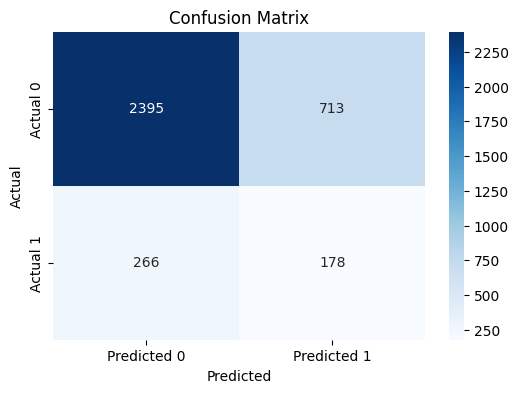

In [13]:
# Confusion matrix
cm = confusion_matrix(df_teste['Numeric_Diagnosed_YN'], df_teste['predict_Diagnosed_YN'])

# Exibindo a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
df_metrics_teste.to_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/04. results/GPTrelev_metricas_teste_MinTL.csv', index=False)
# df_metrics_teste = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/04. results/GPTrelev_metricas_teste_MinTL.csv')

df_teste.to_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/03. prediction/prediction_GPTrelev_MinTL.pkl')

#### Tempo de antecipação
Neste seção vou calcular quanto tempo em média houve de antecipação do risco

In [ ]:
df_teste_clean = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/02. clean/test_clean_corpus.pkl')
df_teste_clean.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,List_CleanText,Qt_Messages
0,A_1857,1,Esse Marcelo é um banana$END_OF_POST$Meu filho...,"[18-Feb-2014 23:28, 18-Feb-2014 23:28, 18-Feb-...","[Esse Marcelo é um banana, Meu filho ninguém c...",2133
1,A_1867,1,Fui tombada por esse site mas como sou fenix r...,"[26-May-2018 18:13, 26-May-2018 18:23, 26-May-...",[Fui tombada por esse site mas como sou fenix ...,1081
2,A_414,1,Aquele momento gente em que tu não está com so...,"[10-May-2015 00:38, 10-May-2015 00:38, 10-May-...",[Aquele momento gente em que tu não está com s...,1596
3,A_486,1,Tenho um xodó nesse user véi kkk Dá até vont...,"[23-Jul-2020 19:34, 04-Nov-2020 22:16, 04-Nov-...",[Tenho um xodó nesse user véi kkk Dá até von...,957
4,A_644,1,@ Fodasseeeeee$END_OF_POST$@ Luann com barba n...,"[26-Jul-2020 12:21, 26-Jul-2020 19:28, 18-Sep-...","[@ Fodasseeeeee, @ Luann com barba não é luann...",103


In [ ]:
df_teste = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/anxiety/01. data/03. prediction/prediction_GPTrelev_MinTL.pkl')

In [ ]:
df_teste_merged = pd.merge(df_teste, df_teste_clean[['User_ID', 'List_Timeline']], on='User_ID', how='left')

In [ ]:
# df_teste_merged['List_Timeline'] = df_teste_merged['List_Timeline'].apply(eval)

In [ ]:
from datetime import datetime

# Função para converter a lista de datas em objetos datetime
def converter_datas(lista_datas_str):
    # Remover os colchetes e espaços em branco
    # lista_datas_str = lista_datas_str.strip('[]').replace("'", "").split(', ')
    # Converter cada data para datetime
    return [pd.to_datetime(data_str, format='%d-%b-%Y %H:%M') for data_str in lista_datas_str]


# Função para calcular a diferença em dias entre duas datas
def calcular_diferenca_dias(data1, data2):
    delta = data1 - data2
    return delta.days

# Aplicando a conversão de datas ao DataFrame
df_teste_merged['List_Timeline'] = df_teste_merged['List_Timeline'].apply(converter_datas)

# Aplicando a função ao DataFrame
df_teste_merged['ultima_data_tweet_lido'] = df_teste_merged.apply(lambda row: row['List_Timeline'][row['qt_msgs_lidas'] - 1], axis=1)
df_teste_merged['ultima_data_tweet_lista'] = df_teste_merged.apply(lambda row: row['List_Timeline'][-1], axis=1)
df_teste_merged['dias_antecipados'] = df_teste_merged.apply(lambda row: calcular_diferenca_dias(row['ultima_data_tweet_lista'], row['ultima_data_tweet_lido']), axis=1)

df_teste_merged.head()

,index,User_ID,Diagnosed_YN,Text,1to10_label,Numeric_Diagnosed_YN,Qt_Messages,label_min,tl_prediction_numeric,media_movel_prediction,predict_Diagnosed_YN,qt_msgs_lidas,List_Timeline,ultima_data_tweet_lido,ultima_data_tweet_lista,dias_antecipados
0,0,CA_14150,no,"[@ Gente ressentida e invejosa! , @ nem deu r...","[3, 2, 1, 2, 2, 0, 1, 1, 1, 3, 2, 1, 1, 6, 2, ...",0,2133,"[2, 2, 3, 6, 2, 6, 2, 1, 2, 2, 3, 2, 2, 2, 1, ...","[2, 2, 3, 6, 2, 6, 2, 1, 2, 2, 3, 2, 2, 2, 1, ...","[1.2, 1.2, 1.2, 1.0, 0.6, 0.6, 0.2, 0.2, 0.4, ...",0,89,"[2014-08-19 17:21:00, 2014-08-19 17:22:00, 201...",2014-11-14 03:58:00,2019-08-07 04:19:00,1727
1,1,CA_14381,no,"[Última semana de férias, o tristeza :( , Que...","[6, 1, 6, 6, 2, 1, 2, 2, 1, 3, 2, 2, 3, 2, 2, ...",0,2133,"[1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, ...","[1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,89,"[2014-02-16 03:56:00, 2014-02-17 02:58:00, 201...",2014-04-21 06:49:00,2020-05-29 23:47:00,2230
2,2,CA_14475,no,[Momentos bons e ruins fazem parte da vida . A...,"[2, 2, 6, 1, 2, 6, 1, 0, 2, 2, 2, 2, 2, 1, 6, ...",0,2133,"[2, 4, 3, 3, 2, 0, 2, 3, 1, 2, 6, 0, 6, 2, 2, ...","[2, 4, 3, 3, 2, 0, 2, 3, 1, 2, 6, 0, 6, 2, 2, ...","[1.6666666666666667, 1.8666666666666667, 2.0, ...",1,69,"[2013-08-16 19:03:00, 2013-08-16 19:53:00, 201...",2013-11-13 16:56:00,2020-05-25 23:44:00,2385
3,3,CA_14701,no,"[daqui a pouco é meu niver, já falei que odeio...","[3, 0, 2, 1, 3, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, ...",0,2133,"[1, 2, 2, 2, 3, 1, 2, 2, 6, 2, 2, 1, 2, 2, 2, ...","[1, 2, 2, 2, 3, 1, 2, 2, 6, 2, 2, 1, 2, 2, 2, ...","[0.6, 0.6, 0.8, 0.8, 0.8, 0.6, 0.6, 0.8, 1.2, ...",0,89,"[2014-02-18 02:25:00, 2014-02-18 02:25:00, 201...",2014-04-11 15:35:00,2020-01-22 19:49:00,2112
4,4,CA_14741,no,"[G.U.Y nos mundiais <3 , sobre a Luciana Genr...","[1, 2, 1, 2, 6, 6, 2, 2, 6, 6, 3, 3, 3, 3, 6, ...",0,2133,"[6, 6, 3, 2, 2, 6, 2, 6, 1, 6, 2, 2, 2, 2, 1, ...","[6, 6, 3, 2, 2, 6, 2, 6, 1, 6, 2, 2, 2, 2, 1, ...","[2.2, 1.8, 1.4, 1.4, 1.6, 1.8, 1.8, 1.8, 1.4, ...",0,89,"[2014-03-22 12:22:00, 2014-10-03 14:55:00, 201...",2015-04-13 01:01:00,2019-09-01 17:16:00,1602


In [ ]:
dias_antecipacao_geral = df_teste_merged['dias_antecipados'].mean()
dias_antecipacao_pos = df_teste_merged[df_teste_merged['Numeric_Diagnosed_YN']==1]['dias_antecipados'].mean()
print(f'Média de dias de antecipação de risco geral: {dias_antecipacao_geral}')
print(f'Média de dias de antecipação de risco da classe positiva: {dias_antecipacao_pos}')

Média de dias de antecipação de risco geral: 518.197072072072
Média de dias de antecipação de risco da classe positiva: 479.22522522522524


In [ ]:
df_teste_merged.to_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/gpt-3/1-10_relevancia/prediction_GPTrelev_MinTL.csv', index=False)

#### Estatística descritiva das classificações de tweets

In [ ]:
df_teste = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/gpt-3/1-10_relevancia/prediction_GPTrelev_MinTL.csv')
df_teste.head()

,index,User_ID,Diagnosed_YN,Text,label,Numeric_Diagnosed_YN,Qt_Messages,label_min,tl_prediction_numeric,media_movel_prediction,soma_movel_prediction,predict_Diagnosed_YN,qt_msgs_lidas,List_Timeline,ultima_data_tweet_lido,ultima_data_tweet_lista,dias_antecipados
0,0,CD_187,no,['@ Na minha cabeça ela tá sujo smp Kkkkkkkkkk...,"['2', '6', '2', '1', '1', '1', '0', '1', '2', ...",0,507,"[2, 0, 1, 2, 2, 1, 1, 2, 1, 6, 0, 0, 1, 0, 1, ...","[2, 0, 1, 2, 2, 1, 1, 2, 1, 6, 0, 0, 1, 0, 1, ...","[0.0, 0.0, 1.8, 1.8, 2.0, 3.0, 2.6, 2.2, 2.2, ...","[0, 0, 9, 9, 10, 15, 13, 11, 11, 10, 9, 9, 3, ...",1,10,"[Timestamp('2021-02-08 23:55:00'), Timestamp('...",2021-02-09 23:10:00,2021-04-09 00:40:00,58
1,1,CD_197,no,['e mais um ponto: a sarah foi transfobica var...,"['2', '3', '2', '3', '0', '3', '2', '6', '2', ...",0,507,"[3, 3, 6, 6, 6, 2, 6, 6, 3, 2, 3, 2, 2, 2, 0, ...","[3, 3, 6, 6, 6, 2, 6, 6, 3, 2, 3, 2, 2, 2, 0, ...","[0.0, 0.0, 6.4, 7.0, 7.0, 6.2, 5.6, 4.8, 4.8, ...","[0, 0, 32, 35, 35, 31, 28, 24, 24, 20, 14, 12,...",1,7,"[Timestamp('2021-03-12 15:07:00'), Timestamp('...",2021-03-12 20:20:00,2021-04-09 17:21:00,27
2,2,CD_198,no,['lumena te odeio mas não vai dar vamo ter que...,"['3', '2', '3', '3', '6', '0', '2', '3', '2', ...",0,507,"[1, 0, 2, 0, 3, 3, 1, 1, 1, 0, 3, 0, 6, 0, 3, ...","[1, 0, 2, 0, 3, 3, 1, 1, 1, 0, 3, 0, 6, 0, 3, ...","[0.0, 0.0, 2.0, 2.0, 2.2, 1.8, 2.4, 1.8, 2.4, ...","[0, 0, 10, 10, 11, 9, 12, 9, 12, 11, 13, 13, 1...",1,9,"[Timestamp('2021-02-28 23:51:00'), Timestamp('...",2021-03-01 01:17:00,2021-04-09 16:00:00,39
3,3,CD_260,no,"['@ só gente bonita torce pro gil, gosto mt ',...","['0', '1', '2', '2', '0', '2', '0', '2', '3', ...",0,507,"[2, 0, 2, 2, 2, 2, 3, 0, 1, 2, 0, 3, 2, 6, 2, ...","[2, 0, 2, 2, 2, 2, 3, 0, 1, 2, 0, 3, 2, 6, 2, ...","[0.0, 0.0, 2.6, 2.2, 2.4, 2.4, 2.0, 2.2, 2.2, ...","[0, 0, 13, 11, 12, 12, 10, 11, 11, 14, 16, 21,...",1,7,"[Timestamp('2021-03-24 23:59:00'), Timestamp('...",2021-03-25 12:35:00,2021-04-09 22:35:00,15
4,4,CD_280,no,['mds o sono que eu tenho não é desse mundo nã...,"['3', '1', '2', '6', '0', '6', '1', '1', '0', ...",0,507,"[0, 2, 0, 0, 1, 0, 2, 3, 2, 1, 2, 1, 6, 0, 6, ...","[0, 2, 0, 0, 1, 0, 2, 3, 2, 1, 2, 1, 6, 0, 6, ...","[0.0, 0.0, 1.0, 1.6, 1.6, 1.8, 2.2, 2.2, 3.4, ...","[0, 0, 5, 8, 8, 9, 11, 11, 17, 15, 18, 16, 15,...",1,11,"[Timestamp('2021-03-10 20:28:00'), Timestamp('...",2021-03-11 20:49:00,2021-04-09 16:54:00,28


In [ ]:
import ast
from collections import Counter

# Tratando os dados de teste
# Transforma a coluna de string para lista
# df_teste['label_min'] = df_teste['label_min'].apply(ast.literal_eval)

# Função para substituir valores não numéricos por 0
def limpar_lista(lista):
    nova_lista = []
    for item in lista:
        try:
            valor = int(item)
            if valor > 10:
              nova_lista.append(10)
            else:
              nova_lista.append(valor)
        except ValueError:
            nova_lista.append(0)  # Substitui por 0 se não for possível converter para inteiro
    return nova_lista

# Aplicar a função para limpar as listas na coluna 'label_min'
df_teste['label_min'] = df_teste['label_min'].apply(limpar_lista)

counter = Counter()
# Iterar sobre cada lista da coluna 'label_min' e atualizar o Counter com as contagens de cada valor
for lista in df_teste['label_min']:
    counter.update(lista)

In [ ]:
counter

Counter({2: 117191,
         3: 40488,
         6: 29055,
         1: 72219,
         0: 54314,
         4: 770,
         7: 1866,
         8: 217,
         5: 8})

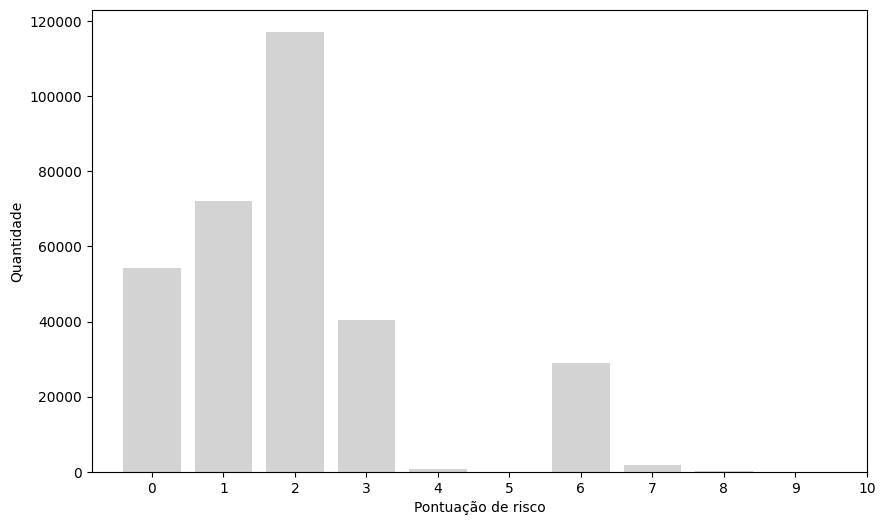

In [ ]:
# Converter o Counter para um DataFrame do pandas para facilitar a plotagem
histogram_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
histogram_df.columns = ['Número', 'Contagem']

# Ordenar os números
histogram_df = histogram_df.sort_values(by='Número')

# Plotar o histograma
plt.figure(figsize=(10, 6))
plt.bar(histogram_df['Número'], histogram_df['Contagem'], color='lightgrey')
plt.xlabel('Pontuação de risco')
plt.ylabel('Quantidade')
plt.xticks(range(11))
plt.show()

In [ ]:
histogram_df['percentual'] = (histogram_df['Contagem'] / histogram_df['Contagem'].sum()) * 100
histogram_df

,Número,Contagem,percentual
4,0,54314,17.181015
3,1,72219,22.844860
0,2,117191,37.070743
1,3,40488,12.807470
5,4,770,0.243572
8,5,8,0.002531
2,6,29055,9.190897
6,7,1866,0.590267
7,8,217,0.068643
